In [39]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import dbscan, OPTICS
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_main = pd.read_csv('/content/leaves.csv')

df_x = df_main.drop(['1', '1.1'], axis='columns')
df_label = df_main['1']

# Scale
scaler = StandardScaler()
x_train = scaler.fit_transform(df_x)

# Apply PCA
pca = PCA(n_components=13)
x_train = pca.fit_transform(x_train)

## k-means

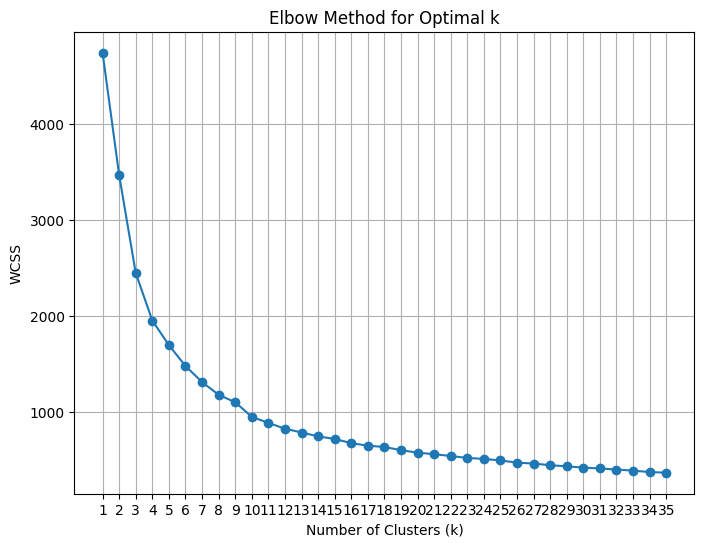

In [63]:
wcss = []
for k in range(1, 36):
    kmeans = KMeans(n_clusters=k, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x_train)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 36), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, 36))
plt.grid(True)
plt.show()

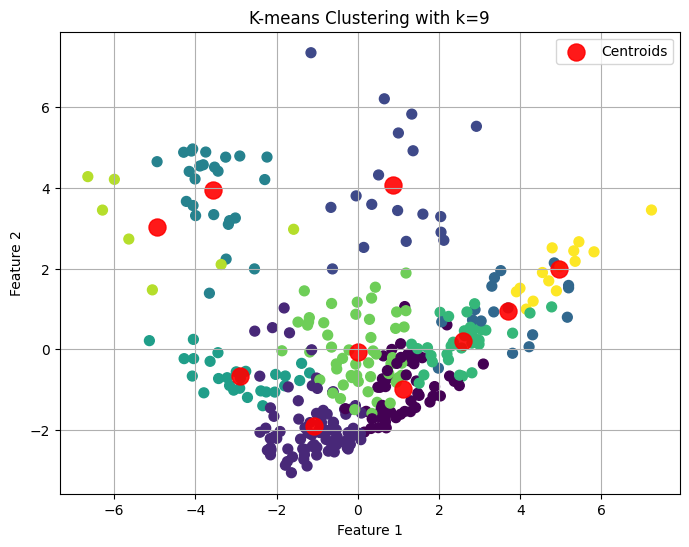

In [71]:
kmeans = KMeans(n_clusters=10,
                max_iter=500,
                n_init=30,
                tol=1e-5,
                random_state=0
                )
labels = kmeans.fit_predict(x_train)

plt.figure(figsize=(8, 6))
plt.scatter(x_train[:, 0], x_train[:, 1], c=labels, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o', c='red', s=150, alpha=0.9, label='Centroids')
plt.title('K-means Clustering with k=9')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## Agglomerative Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Best model: Linkage=ward, Affinity=euclidean


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


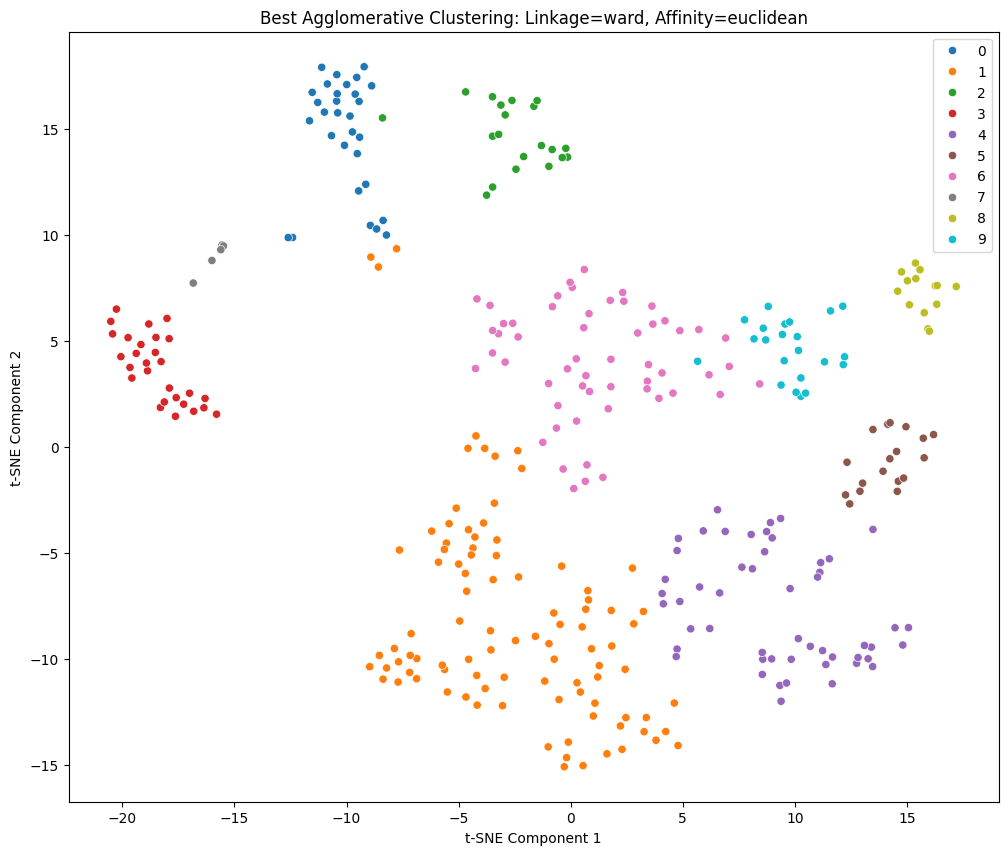

In [72]:
n_clusters = 10

linkages = ['ward', 'complete', 'average', 'single']
affinities = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']

scores = {
    "Linkage": [],
    "Affinity": [],
    "Silhouette Score": [],
    "Davies-Bouldin Index": [],
    "Calinski-Harabasz Index": []
}

for linkage in linkages:
    for affinity in affinities:
        if linkage == 'ward' and affinity != 'euclidean':
            continue

        try:
            if linkage == 'ward':
                agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity='euclidean')
            else:
                agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=affinity)

            labels = agg_clustering.fit_predict(x_train)

            silhouette = silhouette_score(x_train, labels)
            davies_bouldin = davies_bouldin_score(x_train, labels)
            calinski_harabasz = calinski_harabasz_score(x_train, labels)

            scores["Linkage"].append(linkage)
            scores["Affinity"].append(affinity)
            scores["Silhouette Score"].append(silhouette)
            scores["Davies-Bouldin Index"].append(davies_bouldin)
            scores["Calinski-Harabasz Index"].append(calinski_harabasz)

        except Exception as e:
            print(f"Failed for linkage={linkage}, affinity={affinity}: {e}")

scores_df = pd.DataFrame(scores)

best_model_idx = scores_df['Silhouette Score'].idxmax()
best_linkage = scores_df.loc[best_model_idx, 'Linkage']
best_affinity = scores_df.loc[best_model_idx, 'Affinity']
print(f"Best model: Linkage={best_linkage}, Affinity={best_affinity}")

# Plotting the best Agglomerative Clustering results
if best_linkage == 'ward':
    best_agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=best_linkage, affinity='euclidean')
else:
    best_agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=best_linkage, metric=best_affinity)

best_labels = best_agg_clustering.fit_predict(x_train)

# Visualize using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(x_train)

palette = sns.color_palette('tab10', n_colors=n_clusters)
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=best_labels, palette=palette, legend='full')
plt.title(f'Best Agglomerative Clustering: Linkage={best_linkage}, Affinity={best_affinity}')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


## DBSCAN

In [85]:
eps_values = [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 4.25, 4.5, 4.75, 4.9]
min_samples_values = [3, 5, 7, 8, 9, 10, 11, 12]

best_eps_dbscan = None
best_min_samples_dbscan = None
best_score_dbscan = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels_dbscan = dbscan.fit_predict(x_train)

        if len(set(labels_dbscan)) > 1:
            silhouette_avg_dbscan = silhouette_score(x_train, labels_dbscan)
            if silhouette_avg_dbscan > best_score_dbscan:
                best_score_dbscan = silhouette_avg_dbscan
                best_eps_dbscan = eps
                best_min_samples_dbscan = min_samples

print("Best parameters for DBSCAN:")
print(f"eps={best_eps_dbscan}, min_samples={best_min_samples_dbscan}")
print(f"Best silhouette score: {best_score_dbscan:.2f}")

Best parameters for DBSCAN:
eps=4.25, min_samples=8
Best silhouette score: 0.52


## OPTICS

In [110]:
from sklearn.metrics import silhouette_score


eps_values = [1e-5, 1e-4, 0.001]
min_samples_values = [20, 25, 30, 40, 45]
xi_values = np.linspace(0.01, 0.1, 10)

best_eps_optics = None
best_min_samples_optics = None
best_xi_optics = None
best_score_optics = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        for xi in xi_values:
            optics = OPTICS(eps=eps, min_samples=min_samples, xi=xi)
            labels_optics = optics.fit_predict(x_train)

            if len(set(labels_optics)) > 1:
                silhouette_avg_optics = silhouette_score(x_train, labels_optics)
                if silhouette_avg_optics > best_score_optics:
                    best_score_optics = silhouette_avg_optics
                    best_eps_optics = eps
                    best_min_samples_optics = min_samples
                    best_xi_optics = xi

print("\nBest parameters for OPTICS:")
print(f"eps={best_eps_optics}, min_samples={best_min_samples_optics}, xi={best_xi_optics}")
print(f"Best silhouette score: {best_score_optics:.2f}")


Best parameters for OPTICS:
eps=1e-05, min_samples=40, xi=0.030000000000000006
Best silhouette score: 0.35


## Guassian Mixture

Log-Likelihood: 6.641671059914471
Silhouette Score: 0.2563209601972752


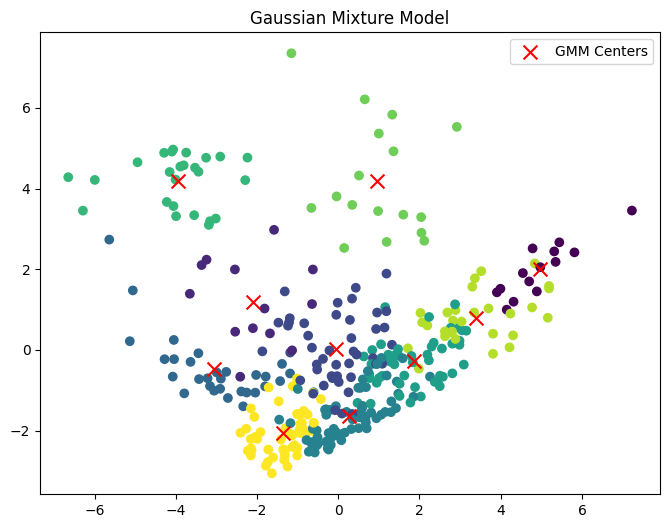

In [112]:
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
gmm.fit(x_train)

print("Log-Likelihood:", gmm.score(X))

labels = gmm.predict(x_train)
silhouette = silhouette_score(x_train, labels)
print("Silhouette Score:", silhouette)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='x', color='red', s=100, label='GMM Centers')
plt.title('Gaussian Mixture Model')
plt.legend()
plt.show()

In [142]:
from sklearn.metrics import silhouette_score


models = [
    ('KMeans', KMeans(n_clusters=10, random_state=42)),
    ('Agglomerative', AgglomerativeClustering(n_clusters=10)),
    ('DBSCAN', DBSCAN(eps=4.25, min_samples=8)),
    ('OPTICS', OPTICS(eps=5, min_samples=40, xi=0.03)),
    ('GMM', GaussianMixture(n_components=10, covariance_type='full', random_state=42))
]

results = []
for name, model in models:
    try:
        labels = model.fit_predict(x_train)
        silhouette = silhouette_score(x_train, labels)
        results.append((name, silhouette))
    except ValueError as e:
        print(f"Error for {name}: {e}")

results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
pd.DataFrame(results_sorted)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,0,1
0,DBSCAN,0.516671
1,OPTICS,0.347394
2,KMeans,0.327922
3,Agglomerative,0.316300
4,GMM,0.256321


In [153]:
X = df_main.drop(['1', '1.1'], axis='columns')
y_true = df_main['1']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = KMeans(n_clusters=10, random_state=42)
cluster_labels = model.fit_predict(X_scaled)


unique_labels = np.unique(y_true)
cluster_counts = np.zeros((len(unique_labels), len(np.unique(cluster_labels))))

for i, true_label in enumerate(unique_labels):
    for j, cluster_label in enumerate(np.unique(cluster_labels)):
        cluster_counts[i, j] = np.sum((y_true == true_label) & (cluster_labels == cluster_label))

cluster_class_counts = pd.DataFrame(cluster_counts, index=unique_labels, columns=np.unique(cluster_labels))
cluster_class_counts.index.name = 'Class'
cluster_class_counts.columns.name = 'Cluster'

cluster_class_counts

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster,0,1,2,3,4,5,6,7,8,9
Class,,,,,,,,,,
1,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,6.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0
6,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,3.0,0.0,0.0,0.0,7.0,0.0,0.0
8,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0
9,0.0,9.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0
